In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim

import torch.distributions as dist
from torch.special import log_ndtr, ndtr
from torch.nn.functional import logsigmoid
from torch.utils.data import DataLoader, TensorDataset


import math
import time
import copy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Logistic LL: Original functions

In [ ]:
def KL_mvn(m, S, mu, Sig):
    """
    Can also be computed via:
        mvn1 = dist.MultivariateNormal(m, S)
        mvn2 = dist.MultivariateNormal(mu, Sig)
        dist.kl.kl_divergence(mvn1, mvn2)
    """
    p = m.size()[0]
    res = 0.5 * (torch.logdet(Sig) - torch.logdet(S) -  p +
                 torch.trace(Sig.inverse() @ S) +
                 (mu - m).t() @ Sig.inverse() @ (mu - m))
    return res


def KL(m, s, mu, sig):
    """
    Compute the KL divergence between two Gaussians
    :param m: mean of variational distribution
    :param s: standard deviation of variational distribution
    :param mu: mean of prior
    :parma sig: standard deviation of prior
    :return: KL divergence
    """
    res = torch.log(sig / s) + 0.5 * ((s ** 2 + (m - mu) ** 2) / sig ** 2 - 1)
    return torch.sum(res)


def KL_MC(m, s, mu, sig):
    """
    Compute the KL divergence between two Gaussians with monte carlo
    :param m: mean of variational distribution
    :param s: standard deviation of variational distribution
    :param mu: mean of prior
    :parma sig: standard deviation of prior
    :return: KL divergence
    """
    d1 = dist.Normal(m, s)
    d2 = dist.Normal(mu, sig)

    x = d1.sample((1000,))
    return torch.mean(torch.sum(d1.log_prob(x) - d2.log_prob(x), 1))


def ELL_TB(m, s, y, X, l_max = 10.0, XX=None):
    """
    Compute the expected negative log-likelihood
    :return: ELL
    """
    M = X @ m

    if XX is None:
        S = torch.sum(X ** 2 * s ** 2, dim=1)
    else:
        S = torch.sum(XX * s ** 2, dim=1)

    S = torch.sqrt(S)

    l = torch.arange(1.0, l_max*2, 1.0, requires_grad=False, dtype=torch.float64)

    M = M.unsqueeze(1)
    S = S.unsqueeze(1)
    l = l.unsqueeze(0)


    res =  \
        torch.dot(- y, X @ m) + \
        torch.sum(
            S / math.sqrt(2 * torch.pi) * torch.exp(- 0.5 * M**2 / S**2) + \
            M * ndtr(M / S)
        ) + \
        torch.sum(
            (-1.0)**(l - 1.0) / l * (
                torch.exp( M @ l + 0.5 * S**2 @ (l ** 2) + log_ndtr(-M / S - S @ l)) + \
                torch.exp(-M @ l + 0.5 * S**2 @ (l ** 2) + log_ndtr( M / S - S @ l))
            )
        )

    return res



def ELL_TB_mvn(m, S, y, X, l_max = 10.0):
    """
    Compute the expected negative log-likelihood
    :return: ELL
    """
    M = X @ m
    # this might be faster
    # S = (X.unsqueeze(1) @ S @ X.unsqueeze(2)).squeeze()

    try:
        U = torch.linalg.cholesky(S)
        S = torch.sum((X @ U) ** 2, dim=1)
    except:
        S = torch.sum(X * (S @ X.t()).t(), dim=1)

    S = torch.sqrt(S)

    l = torch.arange(1.0, l_max*2, 1.0, requires_grad=False, dtype=torch.float64)

    M = M.unsqueeze(1)
    S = S.unsqueeze(1)
    l = l.unsqueeze(0)

    res =  \
        torch.dot(- y, M.squeeze()) + \
        torch.sum(
            S / math.sqrt(2 * torch.pi) * torch.exp(- 0.5 * M**2 / S**2) + \
            M * ndtr(M / S)
        ) + \
        torch.sum(
            (-1.0)**(l - 1.0) / l * (
                torch.exp( M @ l + 0.5 * S**2 @ (l ** 2) + log_ndtr(-M / S - S @ l)) + \
                torch.exp(-M @ l + 0.5 * S**2 @ (l ** 2) + log_ndtr( M / S - S @ l))
            )
        )

    return res


def ELL_MC(m, s, y, X, n_samples=1000):
    """
    Compute the expected negative log-likelihood with monte carlo
    :return: ELL
    """
    # print(f"ELL_MC: m={m} s={s}")

    M = X @ m
    # S = torch.sqrt(X ** 2 @ s ** 2)
    S = torch.sum(X ** 2 * s ** 2, dim=1)
    S = torch.sqrt(S)

    norm = dist.Normal(torch.zeros_like(M), torch.ones_like(S))
    samp = norm.sample((n_samples, ))
    samp = M + S * samp

    res =  torch.dot( - y, M) + \
        torch.sum(torch.mean(torch.log1p(torch.exp(samp)), 0))

    return res


def ELL_MC_mvn(m, S, y, X, n_samples=1000):
    """
    Compute the expected negative log-likelihood with monte carlo
    :return: ELL
    """
    M = X @ m
    # S = torch.diag(X @ S @ X.t())

    try:
        U = torch.linalg.cholesky(S)
        S = torch.sum((X @ U) ** 2, dim=1)
    except:
        S = torch.sum(X * (S @ X.t()).t(), dim=1)

    S = torch.sqrt(S)

    norm = dist.Normal(torch.zeros_like(M), torch.ones_like(S))
    samp = norm.sample((n_samples, ))
    samp = M + S * samp

    res =  torch.dot( - y, M) + \
        torch.sum(torch.mean(torch.log1p(torch.exp(samp)), 0))

    return res


def ELL_Jak(m, s, t, y, X):
    """
    Compute the expected negative log-likelihood using the bound introduced
    by Jaakkola and Jordan (2000)
    :return: ELL
    """
    M = X @ m
    a_t = (torch.sigmoid(t) - 0.5) / t
    S = torch.diag(s**2) + torch.outer(m, m)

    try:
        U = torch.linalg.cholesky(S)
        B = a_t * torch.sum((X @ U) ** 2, dim=1)
    except:
        B = a_t * torch.sum(X * (S @ X.t()).t(), dim=1)

    res = - torch.dot(y, M) - torch.sum(logsigmoid(t)) + \
        0.5 * torch.sum(M + t) + 0.5 * torch.sum(B)   - \
        0.5 * torch.sum(a_t * t ** 2)

    return res


def ELL_Jak_mvn(m, S, t, y, X):
    """
    Compute the expected negative log-likelihood using the bound introduced
    by Jaakkola and Jordan (2000)
    :return: ELL
    """
    M = X @ m
    a_t = (torch.sigmoid(t) - 0.5) / t
    SS = S + torch.outer(m, m)

    try:
        U = torch.linalg.cholesky(SS)
        B = a_t * torch.sum((X @ U) ** 2, dim=1)
    except:
        B = a_t * torch.sum(X * (SS @ X.t()).t(), dim=1)

    res = - torch.dot(y, M) - torch.sum(logsigmoid(t)) + \
        0.5 * torch.sum(M + t) + 0.5 * torch.sum(B)   - \
        0.5 * torch.sum(a_t * t ** 2)

    return res


def ELBO_TB(m, u, y, X, mu, sig, l_max = 10.0, XX=None):
    """
    Compute the negative of the ELBO
    :return: ELBO
    """
    s = torch.exp(u)
    return ELL_TB(m, s, y, X, l_max=l_max, XX=XX) + KL(m, s, mu, sig)


def ELBO_TB_mvn(m, u, y, X, mu, Sig, l_max = 10.0):
    """
    Compute the negative of the ELBO
    :return: ELBO
    """
    p = Sig.size()[0]
    L = torch.zeros(p, p, dtype=torch.double)
    L[torch.tril_indices(p, p, 0).tolist()] = u
    S = L.t() @ L

    return ELL_TB_mvn(m, S, y, X, l_max=l_max) + KL_mvn(m, S, mu, Sig)


def ELBO_MC(m, u, y, X, mu, sig, n_samples=1000):
    """
    Compute the negative of the ELBO
    :return: ELBO
    """
    s = torch.exp(u)
    return ELL_MC(m, s, y, X, n_samples) + KL(m, s, mu, sig)


def ELBO_MC_mvn(m, u, y, X, mu, Sig, n_samples=1000):
    """
    Compute the negative of the ELBO
    :return: ELBO
    """
    p = Sig.size()[0]
    L = torch.zeros(p, p, dtype=torch.double)
    L[torch.tril_indices(p, p, 0).tolist()] = u
    S = L.t() @ L

    return ELL_MC_mvn(m, S, y, X, n_samples) + KL_mvn(m, S, mu, Sig)


def ELBO_Jak(m, s, t, y, X, mu, sig):
    """
    Compute the negative of the ELBO using the bound introduced by
    Jaakkola and Jordan (2000)
    :return: ELBO
    """
    return ELL_Jak(m, s, t, y, X) + KL(m, s, mu, sig)


def ELBO_Jak_mvn(m, S, t, y, X, mu, Sig, cov=None):
    """
    Compute the negative of the ELBO using the bound introduced by
    Jaakkola and Jordan (2000)
    :return: ELBO
    """
    return ELL_Jak_mvn(m, S, t, y, X) + KL_mvn(m, S, mu, Sig)



## Logistic LL: Multi-head functions

In [ ]:
def KL_MH(m_list, s_list, mu_list, sig_list):
    total_KL = sum(KL(m, s, mu, sig) for m, s, mu, sig in zip(m_list, s_list, mu_list, sig_list))
    return total_KL

def KL_mvn_MH(m_list, S_list, mu_list, Sig_list):
    total_KL = sum(KL_mvn(m, S, mu, Sig) for m, S, mu, Sig in zip(m_list, S_list, mu_list, Sig_list))
    return total_KL

def ELL_TB_MH(m_list, s_list, y_list, X, l_max=10.0, XX=None):
    total_ELL = sum(ELL_TB(m, s, y, X, l_max=l_max, XX=XX) for m, s, y in zip(m_list, s_list, y_list))
    return total_ELL

def ELL_TB_mvn_MH(m_list, S_list, y_list, X, l_max=10.0):
    total_ELL = sum(ELL_TB_mvn(m, S, y, X, l_max=l_max) for m, S, y in zip(m_list, S_list, y_list))
    return total_ELL

def ELL_MC_MH(m_list, s_list, y_list, X, n_samples=1000):
    total_ELL = sum(ELL_MC(m, s, y, X, n_samples=n_samples) for m, s, y in zip(m_list, s_list, y_list))
    return total_ELL

def ELL_MC_mvn_MH(m_list, S_list, y_list, X, n_samples=1000):
    total_ELL = sum(ELL_MC_mvn(m, S, y, X, n_samples=n_samples) for m, S, y in zip(m_list, S_list, y_list))
    return total_ELL

## Base model

In [ ]:
class LLModel:

    def __init__(self, p, K, beta=1.0, intercept=False, backbone=None, seed=1):
        """
        Parameters:
        ----------
            p : int
                Dimensionality of the input features after processing by the backbone network.
            K : int
                Number of outputs (labels).
        """
        print(f"[LLModel] beta={beta} input_dim={p} output_dim={K} intercept={intercept}")
        torch.manual_seed(seed)
        self.intercept = intercept
        if intercept:
            p += 1
        self.p = p
        self.K = K
        self.backbone = backbone
        self.beta = beta
        self.seed = seed

        self.params = []
        return p

    def process(self, X_batch):
        if self.backbone is not None:
            X_processed = self.backbone(X_batch)
        else:
            X_processed = X_batch

        if self.intercept:
            X_processed = torch.cat((torch.ones(X_processed.size()[0], 1), X_processed), 1)
        return X_processed

    def train_loss(self, X_batch, y_batch, data_size=None, verbose=False):
        raise ValueError("[LLModel] train_loss not implemented")

    def predict(self, X):
        raise ValueError("[LLModel] predict not implemented")

## Sigmoid-likelihood model

In [ ]:
class LogisticVI(LLModel):
    """
    Variational Inference for Logistic Regression with Multiple Outputs.

    This class implements variational inference for logistic regression with support for multiple outputs (multi-label classification).
    It uses the original functions for computing the KL divergence and expected negative log-likelihood, and builds multihead versions by calling these functions.

    The class assumes that the data loader and training loop are handled externally.
    It provides methods to compute the ELBO and perform optimization steps given batches of data.

    Parameters:
    ----------
    p : int
        Dimensionality of the input features after processing by the backbone network.
    K : int
        Number of outputs (labels).
    method : int, optional
        Method to use for approximating the ELBO:
        - 0: Proposed bound, diagonal covariance variational family.
        - 1: Proposed bound, full covariance variational family.
        - 4: Monte Carlo, diagonal covariance variational family.
        - 5: Monte Carlo, full covariance variational family.
        Default is 0.
    mu : torch.Tensor, optional
        Prior means for each output. Shape (p, K).
    sig : torch.Tensor, optional
        Prior standard deviations for each output. Shape (p, K).
    Sig : list of torch.Tensor, optional
        Prior covariance matrices for each output. List of K tensors, each of shape (p, p).
    m_init : torch.Tensor, optional
        Initial means of the variational distributions. Shape (p, K).
    s_init : torch.Tensor, optional
        Initial standard deviations (or lower-triangular parameters) of the variational distributions. Shape depends on method.
    l_max : float, optional
        Maximum value of l for the proposed bound. Default is 12.0.
    adaptive_l : bool, optional
        Whether to adaptively increase l during training. Default is False.
    n_samples : int, optional
        Number of samples for Monte Carlo estimation. Default is 500.
    seed : int, optional
        Random seed for reproducibility. Default is 1.
    backbone : torch.nn.Module, optional
        Backbone network to transform input features.
    """

    def __init__(self, p, K, method=0, beta=1.0, intercept=False,
                 mu=None, sig=None, Sig=None, m_init=None, s_init=None,
                 l_max=12.0, adaptive_l=False, n_samples=500, seed=1, backbone=None):
        p = super().__init__(p, K, beta=beta, intercept=intercept, backbone=backbone, seed=seed)

        self.method = method
        self.l_max = l_max
        self.adaptive_l = adaptive_l
        self.n_samples = n_samples

        # Initialize prior parameters
        if mu is None:
            self.mu_list = [torch.zeros(p, dtype=torch.double) for _ in range(K)]
        else:
            self.mu_list = [mu[:, k] for k in range(K)]

        if sig is None:
            self.sig_list = [torch.ones(p, dtype=torch.double) for _ in range(K)]
        else:
            self.sig_list = [sig[:, k] for k in range(K)]

        if Sig is None:
            self.Sig_list = [torch.eye(p, dtype=torch.double) for _ in range(K)]
        else:
            self.Sig_list = Sig  # List of K covariance matrices of shape (p, p)

        # Initialize variational parameters
        if m_init is None:
            self.m_list = [torch.randn(p, dtype=torch.double) for _ in range(K)]
        else:
            self.m_list = [m_init[:, k] for k in range(K)]

        if s_init is None:
            if method in [0, 4]:
                self.u_list = [torch.tensor([-1.0] * p, dtype=torch.double) for _ in range(K)]
                self.s_list = [torch.exp(u) for u in self.u_list]
            elif method in [1, 5]:
                self.u_list = []
                for _ in range(K):
                    u = torch.ones(int(p * (p + 1) / 2), dtype=torch.double) * (1.0 / p)
                    u.requires_grad = True
                    self.u_list.append(u)
        else:
            if method in [0, 4]:
                self.s_list = [s_init[:, k] for k in range(K)]
                self.u_list = [torch.log(s) for s in self.s_list]
            elif method in [1, 5]:
                self.u_list = s_init  # Should be list of u tensors for each output

        # Set requires_grad=True for variational parameters
        for m in self.m_list:
            m.requires_grad = True
        for u in self.u_list:
            u.requires_grad = True

        # Collect parameters for optimization
        self.params = list(self.m_list) + list(self.u_list)
        if self.backbone is not None:
            self.params += list(self.backbone.parameters())

        # Initialize l_terms for adaptive l
        if adaptive_l:
            self.l_terms = float(int(l_max / 2))
        else:
            self.l_terms = l_max

    def train_loss(self, X_batch, y_batch, data_size=None, verbose=False):
        data_size = data_size or X_batch.shape[0]
        return -self.compute_ELBO(X_batch, y_batch, data_size, verbose=verbose)

    def compute_ELBO(self, X_batch, y_batch, data_size, verbose=False):
        """
        Compute the Evidence Lower Bound (ELBO) for a batch of data.

        Parameters:
        ----------
        X_batch : torch.Tensor
            Batch of input data. Shape (batch_size, input_dim).
        y_batch : torch.Tensor
            Batch of target variables. Shape (batch_size, K).

        Returns:
        -------
        ELBO : torch.Tensor
            The computed ELBO for the batch.
        """
        X_processed = self.process(X_batch)
        batch_size = X_batch.shape[0]

        # Prepare lists for variational parameters and priors
        m_list = self.m_list
        mu_list = self.mu_list
        y_list = [y_batch[:, k] for k in range(self.K)]

        if self.method in [0, 4]:
            s_list = [torch.exp(u) for u in self.u_list]
            sig_list = self.sig_list

            if self.method == 0:
                likelihood = -ELL_TB_MH(m_list, s_list, y_list, X_processed, l_max=self.l_terms)
                KL_div = KL_MH(m_list, s_list, mu_list, sig_list)
            else:
                likelihood = -ELL_MC_MH(m_list, s_list, y_list, X_processed, n_samples=self.n_samples)
                KL_div = KL_MH(m_list, s_list, mu_list, sig_list)

        elif self.method in [1, 5]:
            L_list = []
            for u in self.u_list:
                L = torch.zeros(self.p, self.p, dtype=torch.double)
                tril_indices = torch.tril_indices(self.p, self.p, 0)
                L[tril_indices[0], tril_indices[1]] = u
                L_list.append(L)

            S_list = [L @ L.t() for L in L_list]
            if self.method == 1:
                likelihood = -ELL_TB_mvn_MH(m_list, S_list, y_list, X_processed, l_max=self.l_terms)
                KL_div = KL_mvn_MH(m_list, S_list, mu_list, self.Sig_list)
            else:
                likelihood = -ELL_MC_mvn_MH(m_list, S_list, y_list, X_processed, n_samples=self.n_samples)
                KL_div = KL_mvn_MH(m_list, S_list, mu_list, self.Sig_list)

        else:
            raise ValueError("Method not recognized")

        mean_log_lik = likelihood/batch_size
        mean_kl_div = KL_div/data_size
        ELBO = mean_log_lik - self.beta*mean_kl_div
        if verbose:
            print(f"ELBO={ELBO:.2f} mean_log_lik={mean_log_lik:.2f} mean_kl_div={mean_kl_div:.2f}")
        return ELBO


    def predict(self, X):
        """
        Predict probabilities for each output given input data.

        Parameters:
        ----------
        X : torch.Tensor
            Input data. Shape (n_samples, input_dim).

        Returns:
        -------
        preds : torch.Tensor
            Predicted probabilities for each output. Shape (n_samples, K).
        """
        X_processed = self.process(X)

        preds = []
        for m in self.m_list:
            pred = torch.sigmoid(X_processed @ m)
            preds.append(pred.unsqueeze(1))

        preds = torch.cat(preds, dim=1)  # Shape: (n_samples, K)
        return preds

## Sigmoid Deterministic model

In [ ]:
class LogisticPointwise(LLModel):

    def __init__(self, p, K, beta=1.0, intercept=False, seed=1, backbone=None,
                 m_init=None,
                 mu=None, Sig=None):
        p = super().__init__(p, K, beta=beta, intercept=intercept, backbone=backbone, seed=seed)

        # Initialize prior parameters
        if mu is None:
            self.mu_list = [torch.zeros(p, dtype=torch.double) for _ in range(K)]
        else:
            self.mu_list = [mu[:, k] for k in range(K)]

        if Sig is None:
            self.Sig_list = [torch.eye(p, dtype=torch.double) for _ in range(K)]
        else:
            self.Sig_list = Sig  # List of K covariance matrices of shape (p, p)

        # Initialize variational parameters
        if m_init is None:
            self.m_list = [torch.randn(p, dtype=torch.double) for _ in range(K)]
        else:
            self.m_list = [m_init[:, k] for k in range(K)]

        # Set requires_grad=True for variational parameters
        for m in self.m_list:
            m.requires_grad = True

        # Collect parameters for optimization
        self.params = list(self.m_list)
        if self.backbone is not None:
            self.params += list(self.backbone.parameters())

    def train_loss(self, X_batch, y_batch, data_size=None, verbose=False):
        data_size = data_size or X_batch.shape[0]

        preds = self.predict(X_batch)
        assert preds.shape == y_batch.shape, f"preds.shape={preds.shape} != y_batch.shape={y_batch.shape}"
        loss = nn.BCELoss(reduction='mean')
        mean_bce = loss(preds, y_batch)
        mean_reg = self.regularization() / data_size

        if verbose:
            print(f"mean_bce_loss={mean_bce:.2f}  mean_reg={mean_reg:.2f}")

        return mean_bce + self.beta * mean_reg

    def regularization(self):
        log_prob = 0.
        for m, prior_mu, prior_Sig in zip(self.m_list, self.mu_list, self.Sig_list):
            # simple prior distribution
            d = torch.distributions.MultivariateNormal(loc=prior_mu, covariance_matrix=prior_Sig)
            log_prob += d.log_prob(m)
        return -log_prob

    def predict(self, X):
        """
        Predict probabilities for each output given input data.

        Parameters:
        ----------
        X : torch.Tensor
            Input data. Shape (n_samples, input_dim).

        Returns:
        -------
        preds : torch.Tensor
            Predicted probabilities for each output. Shape (n_samples, K).
        """
        X_processed = self.process(X)

        preds = []
        for m in self.m_list:
            pred = torch.sigmoid(X_processed @ m)
            preds.append(pred.unsqueeze(1))

        preds = torch.cat(preds, dim=1)  # Shape: (n_samples, K)
        return preds

In [ ]:
!pip install vbll

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
import vbll


class VBLLVI(LLModel):

    def __init__(self, p, K, vbll_cfg, intercept=False, seed=1, backbone=None):
        p = super().__init__(p, K, intercept=intercept, backbone=backbone, seed=seed)
        self.vbll_cfg = vbll_cfg

        self.heads = [self.make_output_layer(num_hidden=p, num_classes=2) for k in range(K)]

        # Collect parameters for optimization
        self.params = []
        if self.backbone is not None:
            self.params += list(self.backbone.parameters())
        for head in self.heads:
            self.params += list(head.parameters())

    def make_output_layer(self, **kwargs):
        if self.vbll_cfg.TYPE == "disc":
            return self._make_disc_vbll_layer(cfg=self.vbll_cfg, **kwargs).double()

        elif self.vbll_cfg.TYPE == "gen":
            return self._make_gen_vbll_layer(cfg=self.vbll_cfg, **kwargs).double()

        else:
            raise ValueError(f"Unknown VBLL type={self.vbll_cfg.TYPE}!")

    def _make_disc_vbll_layer(self, num_hidden, num_classes, cfg):
        """ VBLL Discriminative classification head. """
        return vbll.DiscClassification( num_hidden,
                                        num_classes,
                                        cfg.REG_WEIGHT,
                                        softmax_bound=cfg.SOFTMAX_BOUND,
                                        # return_empirical=cfg.RETURN_EMPIRICAL,
                                        # softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL,
                                        parameterization = cfg.PARAM,
                                        return_ood=cfg.RETURN_OOD,
                                        prior_scale=cfg.PRIOR_SCALE,
                                       )

    def _make_gen_vbll_layer(self, num_hidden, num_classes, cfg):
        """ VBLL Generative classification head. """
        return vbll.GenClassification(  num_hidden,
                                        num_classes,
                                        cfg.REG_WEIGHT,
                                        softmax_bound=cfg.SOFTMAX_BOUND,
                                        # return_empirical=cfg.RETURN_EMPIRICAL,
                                        # softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL,
                                        parameterization = cfg.PARAM,
                                        return_ood=cfg.RETURN_OOD,
                                        prior_scale=cfg.PRIOR_SCALE)

    def train_loss(self, X_batch, y_batch, data_size=None, verbose=False):
        data_size = data_size or X_batch.shape[0]
        X_processed = self.process(X_batch)

        loss = 0.
        for i, (head, y) in enumerate(zip(self.heads, y_batch.T)):
            loss1 = head(X_processed).train_loss_fn(y.long())
            loss += loss1
            if verbose:
                print(f"head={i} loss={loss1:.2f}")

        return loss

    def predict(self, X):
        """
        Predict probabilities for each output given input data.

        Parameters:
        ----------
        X : torch.Tensor
            Input data. Shape (n_samples, input_dim).

        Returns:
        -------
        preds : torch.Tensor
            Predicted probabilities for each output. Shape (n_samples, K).
        """
        X_processed = self.process(X)

        preds = []
        for head in self.heads:
            pred = head(X_processed).predictive.probs[:, 1]
            preds.append(pred.unsqueeze(1))

        preds = torch.cat(preds, dim=1)  # Shape: (n_samples, K)
        return preds

## Synthetic Data from Linear Model

In [ ]:
# Step 1: Generate synthetic data for multi-label classification
# Assume N samples, D input features, and K labels
N = 1000  # number of samples
D = 10    # input features
K = 4     # number of labels (multi-label classification)

bias_on = 1.
noise = 0.25

torch.manual_seed(0)

# Generate random data
X = torch.randn(N, D)

# Generate random weights for true labels
true_W = torch.randn(D, K)
# true_W = torch.ones(D, K)
true_b = torch.randn(K)

# Compute logits
logits = X @ true_W + true_b*bias_on + torch.randn(N, K)*noise

# Apply sigmoid to get probabilities
probs = torch.sigmoid(logits)

# Generate labels (multi-label)
y = torch.bernoulli(probs)  # y is of shape (N, K), with 0s and 1s

# Convert X,y to double precision (to match the expected dtype)
X = X.double()
y = y.double()

In [ ]:
# Generate test data
X_test = torch.randn(10000, D)

# Compute logits
logits = X_test @ true_W + true_b*bias_on + torch.randn(10000, K)*noise

# Apply sigmoid to get probabilities
probs = torch.sigmoid(logits)

# Generate labels (multi-label)
y_test = torch.bernoulli(probs)  # y is of shape (N, K), with 0s and 1s

# Convert X,y to double precision (to match the expected dtype)
X_test  = X_test.double()
y_test = y_test.double()

## Synthethic Data: Shapes

In [ ]:
!wget -q https://raw.githubusercontent.com/matekrk/vi-per/refs/heads/main/generate_data_matchformat.py

In [ ]:
import json
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point, Polygon

from generate_data_matchformat import create_artificialshapes_dataset

Your data path will be: size64_simplicity3_len1024_cbF_cfF_noF


100%|██████████| 1024/1024 [01:01<00:00, 16.75it/s]


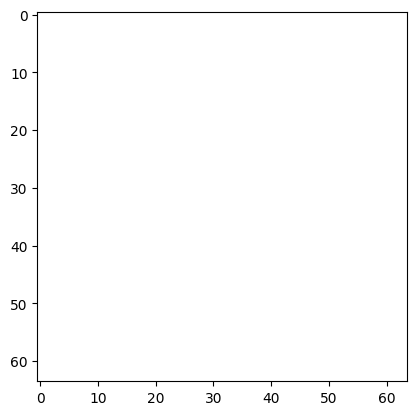

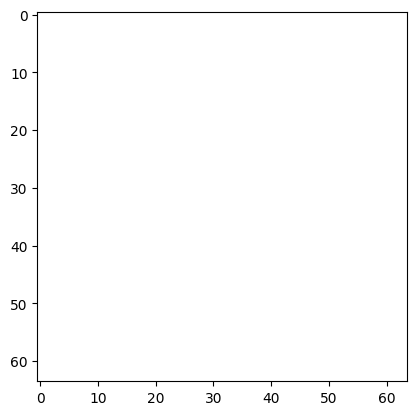

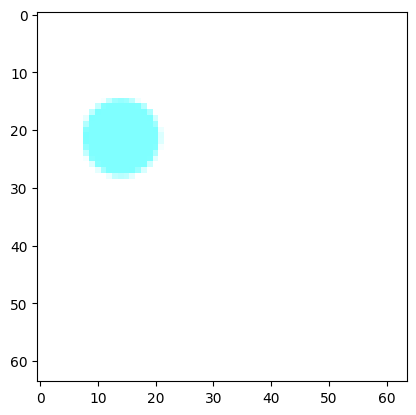

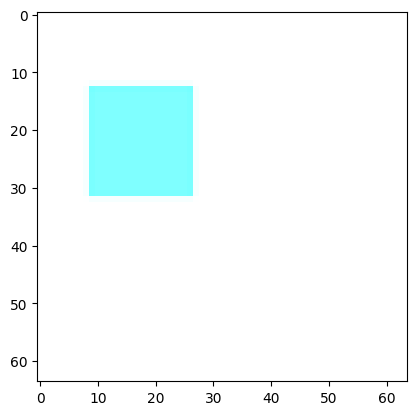

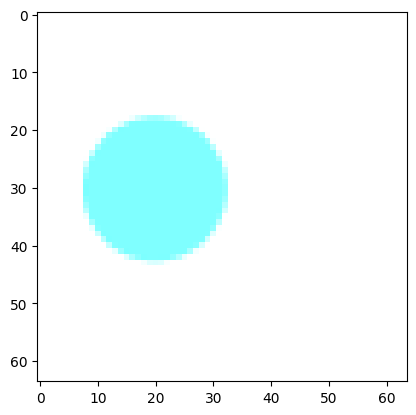

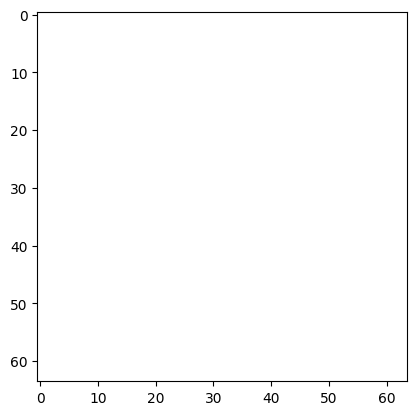

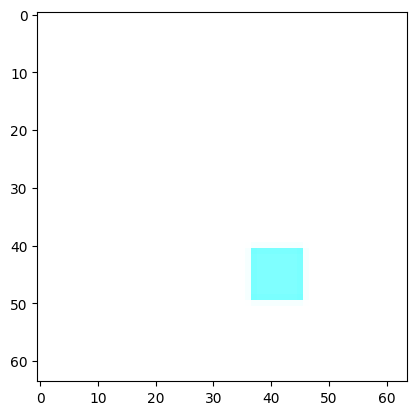

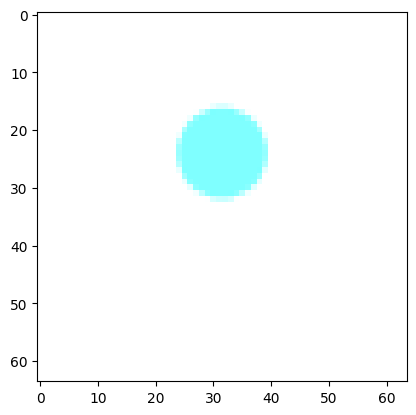

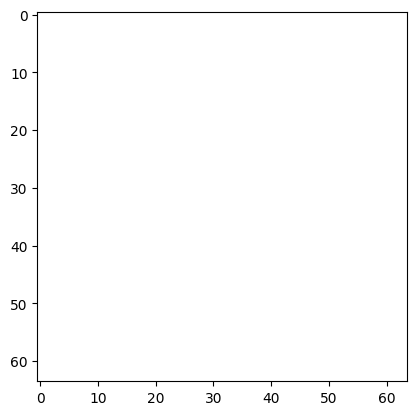

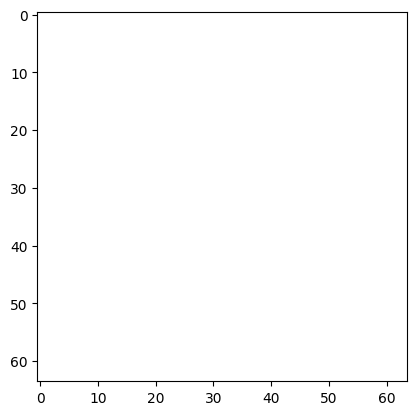

In [ ]:
# Configure and create

size =  64
# N = 256
N = 1024
main_dir = f""

coloured_background = False
coloured_figues = False
no_overlap = False
bias_classes = [0.5, 0.5, 0.0, 0.0, 0.0, 0.0] # None
simplicity = 3

def get_appendix(coloured_background, coloured_figues, no_overlap):
    def get_bool_str(v):
        return "T" if v else "F"
    return f"cb{get_bool_str(coloured_background)}_cf{get_bool_str(coloured_figues)}_no{get_bool_str(no_overlap)}"

path_to_save = os.path.join(main_dir, f"size{size}_" + f"simplicity{simplicity}_" + f"len{N}_" + get_appendix(coloured_background, coloured_figues, no_overlap))

datasetdir = os.path.join(path_to_save, "images")
datasettxt = os.path.join(path_to_save, "data.txt")
labelstxt = os.path.join(path_to_save, "label.txt")
print(f"Your data path will be: {path_to_save}")

dataset, labels = create_artificialshapes_dataset(N, size, datasetdir, datasettxt, labelstxt, no_overlap, coloured_figues, coloured_background, bias_classes, simplicity)

# for inspection
# datasetnpy = os.path.join(path_to_save, "data.npy")
# np.save(datasetnpy, dataset)
# labelsnpy = os.path.join(path_to_save, "label.npy")
# np.save(labelsnpy, labels)


for i in range(10):
    plt.imshow(dataset[i])
    plt.show()


Your data path will be: size64_simplicity3_len1024_cbF_cfF_noF


 34%|███▍      | 349/1024 [00:06<00:13, 50.04it/s]


KeyboardInterrupt: 

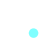

In [ ]:
# Configure and create

size =  64
# N = 256
N = 1024
main_dir = f""

coloured_background = False
coloured_figues = False
no_overlap = False
bias_classes = [0.5, 0.5, 0.0, 0.0, 0.0, 0.0] # None
simplicity = 3

def get_appendix(coloured_background, coloured_figues, no_overlap):
    def get_bool_str(v):
        return "T" if v else "F"
    return f"cb{get_bool_str(coloured_background)}_cf{get_bool_str(coloured_figues)}_no{get_bool_str(no_overlap)}"

path_to_save = os.path.join(main_dir, f"size{size}_" + f"simplicity{simplicity}_" + f"len{N}_" + get_appendix(coloured_background, coloured_figues, no_overlap))

datasetdir = os.path.join(path_to_save, "images")
datasettxt = os.path.join(path_to_save, "data.txt")
labelstxt = os.path.join(path_to_save, "label.txt")
print(f"Your data path will be: {path_to_save}")

dataset, labels = create_artificialshapes_dataset(N, size, datasetdir, datasettxt, labelstxt, no_overlap, coloured_figues, coloured_background, bias_classes, simplicity)

# for inspection
# datasetnpy = os.path.join(path_to_save, "data.npy")
# np.save(datasetnpy, dataset)
# labelsnpy = os.path.join(path_to_save, "label.npy")
# np.save(labelsnpy, labels)


for i in range(10):
    plt.imshow(dataset[i])
    plt.show()


In [ ]:
# Convert labels to flat binary array

shapes = ['disk', 'square', 'triangle', 'star', 'hexagon', 'pentagon']

label_ids = []
K = 0
shape2ix = {shape: i for i, shape in enumerate(shapes)}
for labels1 in labels:
    labels1 = [shape2ix[l[0]] for l in labels1]
    if labels1:
        K = max(K, max(labels1)+1)
    label_ids.append(labels1)

def create_binary_matrix(indices, num_cols):
    return np.array([[1 if j in row else 0 for j in range(num_cols)] for row in indices])

y = create_binary_matrix(label_ids, K)


############################################################
# Flatten Xs

# X = dataset.reshape([len(dataset), -1])
# D = X.shape[-1]

# D = X.shape[1:]
X = dataset
X = X * (1/255)

In [ ]:
X.shape

(1024, 64, 64, 3)

In [ ]:
N = 500  # training data size

X_test = torch.tensor(X[N:]).permute(0, 3, 1, 2).double()
y_test = torch.tensor(y[N:]).double()
X = torch.tensor(X[:N]).permute(0, 3, 1, 2).double()
y = torch.tensor(y[:N]).double()


N, K, X.shape, y.shape, X_test.shape, y_test.shape

(500,
 2,
 torch.Size([500, 3, 64, 64]),
 torch.Size([500, 2]),
 torch.Size([524, 3, 64, 64]),
 torch.Size([524, 2]))

In [ ]:
# Prepare DataLoader
batch_size = 1000

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Backbone

In [ ]:
# Step 2: Define a backbone network
class Backbone(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Backbone, self).__init__()
        self.fc = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc(x))
        x = self.fc2(x)
        return x

In [ ]:
p = 10
D = 3*64**2
backbone = Backbone(D, p).double()

In [ ]:
# # Step 2: Define a backbone network
# class Backbone(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Backbone, self).__init__()
#         self.fc = nn.Linear(input_dim, 1024)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(1024, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, 128)
#         self.fc5 = nn.Linear(128, 128)
#         self.fc6 = nn.Linear(128, output_dim)

#     def forward(self, x):
#         x = self.relu(self.fc(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.relu(self.fc4(x))
#         x = self.relu(self.fc5(x))
#         x = self.fc6(x)
#         return x

In [ ]:
# # Define backbone that outputs features of dimension p

# p = 10  # dimension of features output by backbone
# backbone = Backbone(D, p).double()  # Ensure the backbone uses double precision

In [ ]:
# !wget -q https://raw.githubusercontent.com/matekrk/vi-per/refs/heads/main/src/backbone_cnn.py
# !wget -q https://raw.githubusercontent.com/matekrk/vi-per/refs/heads/main/src/backbone_build.py
# !wget -q https://raw.githubusercontent.com/matekrk/vi-per/refs/heads/main/src/backbone_simple.py

In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channel, option_id):
        super(LeNet, self).__init__() # super().__init__()
        # 0: size 28, 1: size 32, 2: size 64
        options = [[[5, 1, 2], [5, 1, 0]],
                   [[3, 1, 0], [3, 1, 0]],
                   [[5, 1, 2], [5, 1, 0]]] # kernel, stride, padding
        self.option_id = option_id
        option = options[option_id]
        self.conv1 = nn.Conv2d(in_channel, 6, kernel_size=option[0][0], stride=option[0][1], padding=option[0][2])
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=option[1][0], stride=option[1][1], padding=option[1][2])
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        final_size = self.compute_final_size(option_id, in_channel)
        self.fc1 = nn.Linear(16 * final_size * final_size, 120)
        self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, num_classes)

    def compute_final_size(self, option_id, in_channel):
        if in_channel == 3:
            match option_id:
                case 0:
                    return 5
                case 1:
                    return 6
                case 2:
                    return 14
        return

    def forward(self, x):
        out = self.conv1(x)
        out = self.avgpool1(out)
        out = self.conv2(out)
        out = self.avgpool2(out)
        #print(out.shape)
        # out = out.view(out.size(0), -1)
        out = torch.flatten(out, start_dim=1)
        #print(out.shape)
        out = self.fc1(out)
        out = torch.nn.functional.relu(out)
        out = self.fc2(out)
        # out = self.fc3(out)
        return out

In [ ]:
p = 84
backbone = LeNet(3, 2).to(torch.double)

In [ ]:
class ConvNetBigger(nn.Module):
    def __init__(self, input_channels, input_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, stride=1, padding=1)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
        self.final_size = 128 * 7 * 7
        self.fc1 = nn.Linear(self.final_size, 120)
        self.fc2 = nn.Linear(120, 60)

    def forward(self, x):
        x = self.avgpool1(nn.functional.relu(self.conv1(x)))
        x = self.avgpool2(nn.functional.relu(self.conv2(x)))
        x = self.avgpool3(nn.functional.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return x

In [ ]:
p = 60
backbone = ConvNetBigger(3, 64).to(torch.double)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, input_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avgpool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
        self.final_size = 64 * 9 * 9
        self.fc1 = nn.Linear(self.final_size, 64)

    def forward(self, x):
        x = self.avgpool1(nn.functional.relu(self.conv1(x)))
        x = self.avgpool2(nn.functional.relu(self.conv2(x)))
        x = self.avgpool3(nn.functional.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        return x

In [ ]:
p = 64
backbone = ConvNet(3, 64).to(torch.double)

In [ ]:
for name, param in backbone.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Number of parameters: {param.numel()}")

Layer: conv1.weight | Number of parameters: 1728
Layer: conv1.bias | Number of parameters: 64
Layer: conv2.weight | Number of parameters: 36864
Layer: conv2.bias | Number of parameters: 64
Layer: conv3.weight | Number of parameters: 36864
Layer: conv3.bias | Number of parameters: 64
Layer: fc1.weight | Number of parameters: 331776
Layer: fc1.bias | Number of parameters: 64


In [ ]:
backbone

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (fc1): Linear(in_features=5184, out_features=64, bias=True)
)

In [ ]:
# from backbone_cnn import network_9layers

# p = 10
# backbone = network_9layers(p).double()

# backbone(X)

# Configure & Build model

In [ ]:
# # Turn off backbone
# backbone = None
# p = X.shape[-1]

beta = 0.
# beta = 0.  # Turn off KL divergence / regularization

In [ ]:
# # Step 3: Instantiate the LogisticVI model
beta = 1.0
model_logisticvi = LogisticVI(beta=beta,
                   p=p,
                   K=K,
                   method=0, # method==0/1 (proposed bound, diagonal/full covariance)
                   backbone=backbone,
                   l_max=10.0,
                   intercept=True,
                   )

[LLModel] beta=1.0 input_dim=64 output_dim=2 intercept=True


In [ ]:
beta = 0.
model = LogisticPointwise(beta=beta,
                            p=p,
                            K=K,
                            backbone=backbone,
                            intercept=True,
                            )

[LLModel] beta=0.0 input_dim=64 output_dim=3 intercept=True


In [ ]:
# # # Discriminative VBLL
# # class cfg:
# #     TYPE = "disc"
# #     REG_WEIGHT = 1./N
# #     # PARAM = 'diagonal'
# #     PARAM = 'dense'
# #     RETURN_OOD = False
# #     PRIOR_SCALE = 1.
# #     SOFTMAX_BOUND = "jensen"
# #     # RETURN_EMPIRICAL = True
# #     # SOFTMAX_BOUND_EMPIRICAL = "montecarlo"


# ## Generative VBLL
# class cfg:
#     TYPE = "gen"
#     REG_WEIGHT = 1./N
#     PARAM = 'diagonal'
#     # PARAM = 'dense'
#     RETURN_OOD = False
#     PRIOR_SCALE = 1.
#     SOFTMAX_BOUND = "jensen"
#     # RETURN_EMPIRICAL = True
#     # SOFTMAX_BOUND_EMPIRICAL = "montecarlo"


# model = VBLLVI(
#             p=p,
#             K=K,
#             vbll_cfg=cfg,
#             backbone=backbone,
#             intercept=True,
#             )

# Run

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Step 5: Make predictions and evaluate the model
def evaluate(model, X_test, y_test, prefix = ""):
    # Get predictions
    preds = model.predict(X_test)

    # Binarize predictions using a threshold (e.g., 0.5)
    threshold = 0.5
    y_pred = (preds >= threshold).double()
    assert y_pred.shape == y_test.shape, f"y_pred.shape={y_pred.shape} != y_test.shape={y_test.shape}"

    f1s = []

    # Compute evaluation metrics (accuracy and F1-score) per label
    for k in range(K):
        acc = accuracy_score(y_test[:, k].flatten().int().numpy(), y_pred[:, k].int().flatten().numpy())
        precision = precision_score(y_test[:, k].numpy(), y_pred[:, k].numpy())
        recall = recall_score(y_test[:, k].numpy(), y_pred[:, k].numpy())
        f1 = f1_score(y_test[:, k].numpy(), y_pred[:, k].numpy())
        f1s.append(f1)
        print(f"{prefix} : Label {k}: Accuracy = {acc:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1-score = {f1:.2f}")

    return f1s


In [ ]:
evaluate(model, X_test, y_test)

In [ ]:
model.backbone.train()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (fc1): Linear(in_features=5184, out_features=64, bias=True)
)

In [ ]:
# Prepare DataLoader
batch_size = 1000

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# p = 10
# D = 3*64**2
# backbone = Backbone(D, p).double()
# model = LogisticPointwise(beta=beta,
#                             p=p,
#                             K=K,
#                             backbone=backbone,
#                             intercept=True,
#                             )

# Training

In [ ]:
model_init = copy.deepcopy(model)
# model = copy.deepcopy(model_init)

In [ ]:
evaluate(model, X, y, prefix="train")
evaluate(model, X_test, y_test, prefix="test")

train : Label 0: Accuracy = 0.62, F1-score = 0.00
train : Label 1: Accuracy = 0.33, F1-score = 0.49
train : Label 2: Accuracy = 0.35, F1-score = 0.52
test : Label 0: Accuracy = 0.67, F1-score = 0.00
test : Label 1: Accuracy = 0.35, F1-score = 0.52
test : Label 2: Accuracy = 0.35, F1-score = 0.52


[0.0, 0.515003489183531, 0.515003489183531]

In [ ]:
# Define optimizer
# optimizer = optim.Adam(model.params, lr=0.001)
optimizer = optim.Adam(model.params, lr=0.001) # , weight_decay=1e-7

In [ ]:
f1_thres = 0.55
model_best = None

In [ ]:
model.backbone

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (fc1): Linear(in_features=5184, out_features=64, bias=True)
)

New Archi

In [ ]:
# Step 4: Train the model
n_epochs = 300  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model, X, y, prefix="train")
        f1_test = evaluate(model, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_best = copy.deepcopy(model)
        n_test_data_pred = 5
        preds = model.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


mean_bce_loss=0.84  mean_reg=0.58
Epoch 0, Loss: 0.8364
train : Label 0: Accuracy = 0.62, F1-score = 0.00
train : Label 1: Accuracy = 0.67, F1-score = 0.00
train : Label 2: Accuracy = 0.65, F1-score = 0.00
test : Label 0: Accuracy = 0.67, F1-score = 0.00
test : Label 1: Accuracy = 0.65, F1-score = 0.00
test : Label 2: Accuracy = 0.65, F1-score = 0.00
true tensor([[0., 1., 0.],
        [0., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]], dtype=torch.float64) pred tensor([[0.4688, 0.2622, 0.3244],
        [0.4578, 0.2657, 0.3341],
        [0.4664, 0.2602, 0.3233],
        [0.4664, 0.2602, 0.3233],
        [0.4660, 0.2606, 0.3270]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.64  mean_reg=0.58
Epoch 10, Loss: 0.6366
train : Label 0: Accuracy = 0.62, F1-score = 0.00
train : Label 1: Accuracy = 0.67, F1-score = 0.00
train : Label 2: Accuracy = 0.65, F1-score = 0.00
test : Label 0: Accuracy = 0.67, F1-score = 0.00
test : Label 1: Accuracy = 0.65, 

In [ ]:
# Step 4: Train the model
n_epochs = 200  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(200, 200+n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model, X, y, prefix="train")
        f1_test = evaluate(model, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_best = copy.deepcopy(model)
        n_test_data_pred = 5
        preds = model.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


mean_bce_loss=0.28  mean_reg=0.40
Epoch 200, Loss: 0.2841
train : Label 0: Accuracy = 0.86, F1-score = 0.67
train : Label 1: Accuracy = 0.87, F1-score = 0.71
test : Label 0: Accuracy = 0.75, F1-score = 0.44
test : Label 1: Accuracy = 0.77, F1-score = 0.46
true tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64) pred tensor([[0.2630, 0.5407],
        [0.0098, 0.0104],
        [0.0098, 0.0104],
        [0.0098, 0.0104],
        [0.0098, 0.0104]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.27  mean_reg=0.40
Epoch 210, Loss: 0.2709
train : Label 0: Accuracy = 0.86, F1-score = 0.66
train : Label 1: Accuracy = 0.88, F1-score = 0.76
test : Label 0: Accuracy = 0.74, F1-score = 0.45
test : Label 1: Accuracy = 0.77, F1-score = 0.53
true tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64) pred tensor([[0.1839, 0.5976],
        [0.0131, 0.0123],
        [0.0131,

In [ ]:
evaluate(model, X, y, prefix="train")

train : Label 0: Accuracy = 0.77, F1-score = 0.00
train : Label 1: Accuracy = 0.81, F1-score = 0.58


[0.0, 0.5752212389380531]

In [ ]:
torch.save(model.backbone.state_dict(), "./backbone_circlessquares.pt")
for i, m in enumerate(model.m_list):
  torch.save(m, f"./att_{i}.pt")

AttributeError: module 'torch' has no attribute 'sa'

With wd

In [ ]:
# Step 4: Train the model
n_epochs = 200  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model, X, y, prefix="train")
        f1_test = evaluate(model, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_best = copy.deepcopy(model)
        n_test_data_pred = 5
        preds = model.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


mean_bce_loss=0.60  mean_reg=0.38
Epoch 0, Loss: 0.6033
train : Label 0: Accuracy = 0.77, F1-score = 0.00
train : Label 1: Accuracy = 0.74, F1-score = 0.00
test : Label 0: Accuracy = 0.73, F1-score = 0.00
test : Label 1: Accuracy = 0.76, F1-score = 0.00
true tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64) pred tensor([[0.1837, 0.2262],
        [0.1821, 0.2227],
        [0.1821, 0.2227],
        [0.1821, 0.2227],
        [0.1821, 0.2227]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.54  mean_reg=0.38
Epoch 10, Loss: 0.5353
train : Label 0: Accuracy = 0.77, F1-score = 0.00
train : Label 1: Accuracy = 0.74, F1-score = 0.00
test : Label 0: Accuracy = 0.73, F1-score = 0.00
test : Label 1: Accuracy = 0.76, F1-score = 0.00
true tensor([[0., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64) pred tensor([[0.2120, 0.2348],
        [0.1839, 0.1894],
        [0.1839, 0.

KeyboardInterrupt: 

Without wd

In [ ]:
# Step 4: Train the model
n_epochs = 100  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model, X, y, prefix="train")
        f1_test = evaluate(model, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_best = copy.deepcopy(model)
        n_test_data_pred = 5
        preds = model.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


mean_bce_loss=0.70  mean_reg=0.38
Epoch 0, Loss: 0.6991
train : Label 0: Accuracy = 0.75, F1-score = 0.00
train : Label 1: Accuracy = 0.73, F1-score = 0.00
test : Label 0: Accuracy = 0.75, F1-score = 0.00
test : Label 1: Accuracy = 0.73, F1-score = 0.00
true tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 1.]], dtype=torch.float64) pred tensor([[0.1916, 0.2827],
        [0.1768, 0.2707],
        [0.1858, 0.2783],
        [0.1768, 0.2707],
        [0.1776, 0.2711]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.56  mean_reg=0.38
Epoch 10, Loss: 0.5632
train : Label 0: Accuracy = 0.75, F1-score = 0.00
train : Label 1: Accuracy = 0.73, F1-score = 0.00
test : Label 0: Accuracy = 0.75, F1-score = 0.00
test : Label 1: Accuracy = 0.73, F1-score = 0.00
true tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 1.]], dtype=torch.float64) pred tensor([[0.3183, 0.3413],
        [0.2666, 0.2708],
        [0.3018, 0.

In [ ]:
evaluate(model, X, y, prefix="train")
evaluate(model, X_test, y_test, prefix="test")

train : Label 0: Accuracy = 0.86, F1-score = 0.66
train : Label 1: Accuracy = 0.88, F1-score = 0.76
test : Label 0: Accuracy = 0.75, F1-score = 0.43
test : Label 1: Accuracy = 0.77, F1-score = 0.57


[0.4291845493562232, 0.5693430656934306]

In [ ]:
model.predict(X_test[0:20]), y_test[0:20]

(tensor([[0.2228, 0.6997],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.1942, 0.5489],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.2821, 0.5432],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.0229, 0.0300],
         [0.1917, 0.6382]], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([[0., 1.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 1.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 1.]], dtype=torch.float64))

### Pointwise

In [ ]:
p = 64
backbone = ConvNet(3, 64).to(torch.double)
beta = 0.
model = LogisticPointwise(beta=beta,
                            p=p,
                            K=K,
                            backbone=backbone,
                            intercept=True,
                            )
model.backbone.train()
evaluate(model, X_test, y_test)

[LLModel] beta=0.0 input_dim=64 output_dim=2 intercept=True
 : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
 : Label 1: Accuracy = 0.75, Precision = 0.45, Recall = 0.59, F1-score = 0.51


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0.0, 0.5093632958801498]

In [ ]:
model_init = copy.deepcopy(model)
f1_thres = 0.55
model_best = None
optimizer = optim.Adam(model.params, lr=0.001)


In [ ]:
# Step 4: Train the model
n_epochs = 500  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model, X, y, prefix="train")
        f1_test = evaluate(model, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_best = copy.deepcopy(model)
          torch.save(model_best.backbone.state_dict(), "./point_backbone_circlessquares.pt")
          for i, m in enumerate(model_best.m_list):
            torch.save(m, f"./point_att_{i}.pt")
        n_test_data_pred = 5
        preds = model.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


mean_bce_loss=0.69  mean_reg=0.40
Epoch 0, Loss: 0.6910


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.1775, 0.0239],
        [0.1775, 0.0239],
        [0.1773, 0.0245],
        [0.1775, 0.0239],
        [0.1814, 0.0257]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.57  mean_reg=0.40
Epoch 10, Loss: 0.5739


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.2730, 0.3091],
        [0.2730, 0.3091],
        [0.2724, 0.3108],
        [0.2730, 0.3091],
        [0.2760, 0.3147]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.56  mean_reg=0.40
Epoch 20, Loss: 0.5625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.2637, 0.2232],
        [0.2637, 0.2232],
        [0.2679, 0.2387],
        [0.2637, 0.2232],
        [0.2837, 0.2803]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.55  mean_reg=0.40
Epoch 30, Loss: 0.5459


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.1865, 0.1065],
        [0.1865, 0.1065],
        [0.2038, 0.1505],
        [0.1865, 0.1065],
        [0.2812, 0.3407]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.52  mean_reg=0.40
Epoch 40, Loss: 0.5207


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.80, Precision = 0.76, Recall = 0.30, F1-score = 0.44


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.79, Precision = 0.59, Recall = 0.17, F1-score = 0.26
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.1798, 0.0883],
        [0.1798, 0.0883],
        [0.2166, 0.1710],
        [0.1798, 0.0883],
        [0.3785, 0.6161]], dtype=torch.float64, grad_fn=<CatBackward0>)
mean_bce_loss=0.48  mean_reg=0.40
Epoch 50, Loss: 0.4822
train : Label 0: Accuracy = 0.75, Precision = 0.55, Recall = 0.30, F1-score = 0.38
train : Label 1: Accuracy = 0.79, Precision = 0.65, Recall = 0.38, F1-score = 0.48
test : Label 0: Accuracy = 0.72, Precision = 0.49, Recall = 0.22, F1-score = 0.31
test : Label 1: Accuracy = 0.79, Precision = 0.53, Recall = 0.24, F1-score = 0.33
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.1147, 0.0417],
   

### LogisticVI

In [ ]:
beta = 1.0
model_logisticvi = LogisticVI(beta=beta,
                   p=p,
                   K=K,
                   method=0, # method==0/1 (proposed bound, diagonal/full covariance)
                   backbone=backbone,
                   l_max=10.0,
                   intercept=True,
                   )

[LLModel] beta=1.0 input_dim=64 output_dim=2 intercept=True


In [ ]:
model_logisticvi_init = copy.deepcopy(model_logisticvi)

In [ ]:
evaluate(model_logisticvi, X_test, y_test)
model_logisticvi.backbone.train()

 : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
 : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool3): AvgPool2d(kernel_size=2, stride=2, padding=1)
  (fc1): Linear(in_features=5184, out_features=64, bias=True)
)

In [ ]:
# model_logisticvi = copy.deepcopy(model_logisticvi_init)

In [ ]:
evaluate(model_logisticvi, X, y, prefix="train")
evaluate(model_logisticvi, X_test, y_test, prefix="test")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0.0, 0.0]

In [ ]:
optimizer = optim.Adam(model_logisticvi.params, lr=0.001)

In [ ]:
f1_thres = 0.55
model_best = None

In [ ]:
# Step 4: Train the model
n_epochs = 500  # Set to a small value for this example

data_size = X.shape[0]
for epoch in range(n_epochs):
    verbose = (epoch%10==0)

    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        loss = model_logisticvi.train_loss(X_batch, y_batch, data_size, verbose=verbose)
        loss.backward()
        # for i in model_logisticvi.params:
        #   print(i.grad)
        optimizer.step()

    if verbose:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
        evaluate(model_logisticvi, X, y, prefix="train")
        f1_test = evaluate(model_logisticvi, X_test, y_test, prefix="test")
        f1_test = sum(f1_test) / len(f1_test)
        if f1_test > f1_thres:
          f1_thres = f1_test
          model_logisticvi_best = copy.deepcopy(model_logisticvi)
          torch.save(model_logisticvi_best.backbone.state_dict(), "./logisticvi_backbone_circlessquares.pt")
          for i, m in enumerate(model_logisticvi_best.m_list):
            torch.save(m, f"./logisticvi_att_{i}.pt")
        n_test_data_pred = 5
        preds = model_logisticvi.predict(X_test[0:n_test_data_pred])
        print("true", y_test[0:n_test_data_pred], "pred", preds)


ELBO=-1.66 mean_log_lik=-1.35 mean_kl_div=0.31
Epoch 0, Loss: 1.6606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.0706, 0.0289],
        [0.0706, 0.0289],
        [0.0716, 0.0298],
        [0.0706, 0.0289],
        [0.0720, 0.0320]], dtype=torch.float64, grad_fn=<CatBackward0>)
ELBO=-1.47 mean_log_lik=-1.17 mean_kl_div=0.30
Epoch 10, Loss: 1.4695


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.2293, 0.1841],
        [0.2293, 0.1841],
        [0.2320, 0.1910],
        [0.2293, 0.1841],
        [0.2406, 0.2142]], dtype=torch.float64, grad_fn=<CatBackward0>)
ELBO=-1.42 mean_log_lik=-1.12 mean_kl_div=0.30
Epoch 20, Loss: 1.4177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.78, Precision = 0.00, Recall = 0.00, F1-score = 0.00
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.2557, 0.2294],
        [0.2557, 0.2294],
        [0.2648, 0.2665],
        [0.2557, 0.2294],
        [0.3231, 0.3896]], dtype=torch.float64, grad_fn=<CatBackward0>)
ELBO=-1.29 mean_log_lik=-0.99 mean_kl_div=0.30
Epoch 30, Loss: 1.2860
train : Label 0: Accuracy = 0.72, Precision = 0.43, Recall = 0.20, F1-score = 0.27
train : Label 1: Accuracy = 0.76, Precision = 0.52, Recall = 0.69, F1-score = 0.59
test : Label 0: Accuracy = 0.72, Precision = 0.49, Recall = 0.20, F1-score = 0.29
test : Label 1: Accuracy = 0.76, Precision = 0.47, Recall = 0.67, F1-score = 0.55
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.2259,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train : Label 0: Accuracy = 0.74, Precision = 0.00, Recall = 0.00, F1-score = 0.00
train : Label 1: Accuracy = 0.82, Precision = 0.68, Recall = 0.55, F1-score = 0.61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test : Label 0: Accuracy = 0.72, Precision = 0.00, Recall = 0.00, F1-score = 0.00
test : Label 1: Accuracy = 0.80, Precision = 0.54, Recall = 0.48, F1-score = 0.51
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.1226, 0.1045],
        [0.1226, 0.1045],
        [0.2461, 0.6363],
        [0.1226, 0.1045],
        [0.3115, 0.7027]], dtype=torch.float64, grad_fn=<CatBackward0>)
ELBO=-1.31 mean_log_lik=-1.03 mean_kl_div=0.28
Epoch 70, Loss: 1.3135
train : Label 0: Accuracy = 0.81, Precision = 0.69, Recall = 0.54, F1-score = 0.60
train : Label 1: Accuracy = 0.82, Precision = 0.86, Recall = 0.34, F1-score = 0.48
test : Label 0: Accuracy = 0.72, Precision = 0.51, Recall = 0.33, F1-score = 0.40
test : Label 1: Accuracy = 0.81, Precision = 0.72, Recall = 0.23, F1-score = 0.34
true tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 0.]], dtype=torch.float64) pred tensor([[0.0331,

### Sigmoid

# [WIP] Real-life dataset

See datasets @ https://www.uco.es/kdis/mllresources/#Corel16kDesc

In [ ]:
# !pip install torch torchtext nltk
# # !pip install --upgrade torch torchtext nltk


In [ ]:
# import nltk

# nltk.download('punkt_tab')

In [ ]:
# import torch
# from torch.utils.data import DataLoader, Dataset
# from torch.nn.utils.rnn import pad_sequence
# from torchtext.vocab import GloVe
# from nltk.corpus import reuters
# import nltk
# nltk.download('reuters')
# nltk.download('punkt')

# # Load the Reuters dataset
# categories = reuters.categories()  # list of all categories (multi-labels)
# documents = reuters.fileids()

# # Split into train and test sets
# train_docs = [doc for doc in documents if doc.startswith("train")]
# test_docs = [doc for doc in documents if doc.startswith("test")]

# # Tokenize and preprocess documents
# def tokenize_and_preprocess(doc_id):
#     tokens = nltk.word_tokenize(reuters.raw(doc_id))
#     return tokens

# train_tokens = [tokenize_and_preprocess(doc_id) for doc_id in train_docs]
# test_tokens = [tokenize_and_preprocess(doc_id) for doc_id in test_docs]

# # Create multi-labels for documents
# def get_labels(doc_id):
#     labels = torch.zeros(len(categories))
#     for category in reuters.categories(doc_id):
#         labels[categories.index(category)] = 1.0
#     return labels

# train_labels = [get_labels(doc_id) for doc_id in train_docs]
# test_labels = [get_labels(doc_id) for doc_id in test_docs]

# # Build Vocabulary and Embeddings
# glove = GloVe(name='6B', dim=100)
# def vectorize(tokens):
#     vectors = [glove[token] for token in tokens if token in glove.stoi]
#     return torch.stack(vectors) if vectors else torch.empty(0, 100)

# train_vectors = [vectorize(tokens) for tokens in train_tokens]
# test_vectors = [vectorize(tokens) for tokens in test_tokens]